In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import scipy.io as sio
import pandas as pd
import math
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sn 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from collections import Counter 

In [ ]:
# Read In Datasets
eog_data = "/content/drive/MyDrive/Datasets/EOG data"

eog1 = sio.loadmat(eog_data+"/S1/EOG.mat")
ctrl1 = sio.loadmat(eog_data+"/S1/ControlSignal.mat")
target1 = sio.loadmat(eog_data+"/S1/TargetGA.mat")

eog2 = sio.loadmat(eog_data+"/S2/EOG.mat")
ctrl2 = sio.loadmat(eog_data+"/S2/ControlSignal.mat")
target2 = sio.loadmat(eog_data+"/S2/TargetGA.mat")

eog3 = sio.loadmat(eog_data+"/S3/EOG.mat")
ctrl3 = sio.loadmat(eog_data+"/S3/ControlSignal.mat")
target3 = sio.loadmat(eog_data+"/S3/TargetGA.mat")

eog4 = sio.loadmat(eog_data+"/S4/EOG.mat")
ctrl4 = sio.loadmat(eog_data+"/S4/ControlSignal.mat")
target4 = sio.loadmat(eog_data+"/S4/TargetGA.mat")

eog5 = sio.loadmat(eog_data+"/S5/EOG.mat")
ctrl5 = sio.loadmat(eog_data+"/S5/ControlSignal.mat")
target5 = sio.loadmat(eog_data+"/S5/TargetGA.mat")

eog6 = sio.loadmat(eog_data+"/S6/EOG.mat")
ctrl6 = sio.loadmat(eog_data+"/S6/ControlSignal.mat")
target6 = sio.loadmat(eog_data+"/S6/TargetGA.mat")

# Take transpose to make dataframe
TargetGA_1 = target1['TargetGA'].T
TargetGA_2 = target2['TargetGA'].T
TargetGA_3 = target3['TargetGA'].T
TargetGA_4 = target4['TargetGA'].T
TargetGA_5 = target5['TargetGA'].T
TargetGA_6 = target6['TargetGA'].T

tah = np.concatenate((TargetGA_1[0], TargetGA_2[0], TargetGA_3[0], TargetGA_4[0], TargetGA_5[0],TargetGA_6[0]))
tav = np.concatenate((TargetGA_1[1], TargetGA_2[1], TargetGA_3[1], TargetGA_4[1], TargetGA_5[1],TargetGA_6[1]))

len(tah)

3600

In [ ]:
def get_eog_data(saccade,eogh,eogv, EOG):
  e = []    #h,v
  Sac = []
  k = saccade[0]
  for i in range(len(eogh)):
    if saccade[i] != k and saccade[i] !=2:
      e = np.array(e)
      EOG.append(e)
      k = saccade[i]
      e = []
    e.append(eogh[i])
    e.append(eogv[i])
  return EOG

In [ ]:
def calculate_angle(tah,tav):
  x_comp,y_comp = [] ,[]
  Angle = []
  for i in range(len(tah)):
    x = tah[i]
    y = tav[i]
    # calculate angle from +ve x axis (0,360)
    angle = np.rad2deg(math.atan2(y,x)) % 360
    Angle.append(angle)
    # components
    y_comp.append(y)
    x_comp.append(x)

  return (x_comp,y_comp,Angle) 

In [ ]:
def get_class(x_comp,y_comp,Angle):
  label = []
  vak_class = []
  for i in range(len(Angle)):
    if (Angle[i]>0 and Angle[i]<= 22.5) or (Angle[i]>337.5 and Angle[i]< 360) or ( Angle[i] == 0 and y_comp[i]!= 0):
      # 1 is construct-words
      label.append(1)
      vak_class.append(2)  # A

    if (Angle[i]<=67.5 and Angle[i]> 22.5) :
      # 2 is construct-visual
      label.append(2)
      vak_class.append(1)  # V

    if (Angle[i]>67.5 and Angle[i]<= 112.5) :
      # 3 is smell
      label.append(3)
      vak_class.append(0)  # None

    if (Angle[i]>112.5 and Angle[i]<= 157.5) :
      # 4 is ext-int-memory
      label.append(4)
      vak_class.append(1)  # V

    if (Angle[i]>157.5 and Angle[i]<= 202.5) :
      # 5 is auditory
      label.append(5)
      vak_class.append(2)  # A

    if (Angle[i]>202.5 and Angle[i]<= 247.5) :
      # 6 is emotion-feelings
      label.append(6)
      vak_class.append(3)  # K

    if (Angle[i]>247.5 and Angle[i]<= 292.5) :
      # 7 is taste
      label.append(7)
      vak_class.append(0)  # None

    if (Angle[i]>292.5 and Angle[i]<= 337.5) :
      # 8 is emotion-bodysense
      label.append(8)
      vak_class.append(3)  # K

    if (Angle[i]== 0 and x_comp[i]== 0 and y_comp[i]==0):
      # 0 is center
      label.append(0)
      vak_class.append(0)  # None

  return (label,vak_class)

In [ ]:
def make_dataframe():
  EOG = []
  EOG= get_eog_data(ctrl1['ControlSignal'][0], eog1['EOG'][0], eog1['EOG'][1] ,EOG)
  EOG= get_eog_data(ctrl2['ControlSignal'][0], eog2['EOG'][0], eog2['EOG'][1] , EOG)
  EOG = get_eog_data(ctrl3['ControlSignal'][0], eog3['EOG'][0], eog3['EOG'][1] , EOG)
  EOG = get_eog_data(ctrl4['ControlSignal'][0], eog4['EOG'][0], eog4['EOG'][1] , EOG)
  EOG = get_eog_data(ctrl5['ControlSignal'][0], eog5['EOG'][0], eog5['EOG'][1] , EOG)
  EOG= get_eog_data(ctrl6['ControlSignal'][0], eog6['EOG'][0], eog6['EOG'][1] , EOG)

  (x_comp,y_comp,Angle) = calculate_angle(tah,tav)
  (label,vak_class) = get_class(x_comp,y_comp,Angle)
  
  dataset = {'EOG':EOG,'label':label,'Angle':Angle, 'class':vak_class, 'X Comp':x_comp, 'Y Comp':y_comp,}
  df = pd.DataFrame(dataset)
  
  return (df,dataset)


In [ ]:
(df,dataset) = make_dataframe()

In [ ]:
# df.to_csv('EOG.csv',index = False,dtype='float32')

In [ ]:
# d = pd.read_csv('EOG.csv',dtype='float32')
# d

In [ ]:
def balance_data(df):
  # pad the EOG sequences
  EOG_padded = tf.keras.preprocessing.sequence.pad_sequences(
    df['EOG'], padding="pre", dtype='float32' )

  # over sample minority class
  overs = SMOTE()
  EOG_padded,vak_class = overs.fit_resample(EOG_padded,df['class'])
  return (EOG_padded,vak_class)


In [ ]:
(EOG_padded,vak_class) = balance_data(df)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train_padded, X_test_padded, y_train, y_test = train_test_split( EOG_padded, vak_class, test_size=0.2, random_state=4)

In [ ]:
# One hot encoding
y_train = np.array(y_train)
y_test = np.array(y_test)
num_classes = 4
y_train_one_hot = np_utils.to_categorical(y_train,num_classes)
y_test_one_hot = np_utils.to_categorical(y_test,num_classes)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3,p=2)
neigh.fit(X_train_padded, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

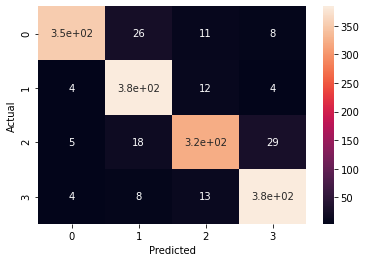

In [ ]:
y_pred=neigh.predict(X_test_padded)

confusion_matrix=pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted'])
sn.heatmap(confusion_matrix,annot=True)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:',accuracy)

Accuracy: 0.910410094637224


In [ ]:
count = Counter(y_pred)
count_sum = count[1]+count[2]+count[3]
visual = 100* count[1]/count_sum
audit = 100* count[2]/count_sum
kines = 100* count[3]/count_sum

print("Visual:", round(visual,2),"%")
print("Auditory:", round(audit,2),"%")
print("Kinesthetic:", round(kines,2),"%")

Visual: 35.74 %
Auditory: 29.43 %
Kinesthetic: 34.84 %


In [ ]:
import joblib
joblib.dump(neigh, 'eog_model.pkl')
model = joblib.load('eog_model.pkl' , mmap_mode ='r')
y_pred1 = model.predict(X_test_padded) 
accuracy_score(y_test,y_pred1)

0.910410094637224

In [ ]:
import pickle

train_test_data = {'X_train_padded':X_train_padded, 'X_test_padded':X_test_padded, 'y_train':y_train, 'y_test':y_test}

# Store data (serialize)
with open('train_test_data.pickle', 'wb') as file:
    pickle.dump(train_test_data, file, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# Load data (deserialize)
with open('train_test_data.pickle', 'rb') as file:
    data = pickle.load(file)

data

{'X_test_padded': array([[    0.      ,     0.      ,     0.      , ...,  -179.60475 ,
           287.9239  ,  -178.23112 ],
        [    0.      ,     0.      ,     0.      , ...,  1263.2612  ,
           432.5039  ,  1262.606   ],
        [    0.      ,     0.      ,     0.      , ...,  -669.2541  ,
         -1372.0204  ,  -665.76825 ],
        ...,
        [    0.      ,     0.      ,     0.      , ..., -1464.7695  ,
           -77.344696, -1463.0955  ],
        [    0.      ,     0.      ,     0.      , ...,  -726.99634 ,
         -1422.7363  ,  -727.00586 ],
        [    0.      ,     0.      ,     0.      , ..., -1192.1366  ,
          1795.7418  , -1190.1003  ]], dtype=float32),
 'X_train_padded': array([[    0.      ,     0.      ,     0.      , ...,  1593.7415  ,
         -1586.6338  ,  1594.2483  ],
        [    0.      ,     0.      ,     0.      , ...,   -51.04249 ,
           509.21487 ,   -51.66865 ],
        [    0.      ,     0.      ,     0.      , ..., -1011.93445 ,
 

In [ ]:
model = joblib.load('eog_model.pkl' , mmap_mode ='r')
test_X = data['X_test_padded']
pred_y = model.predict(test_X)

In [ ]:
pred_y.shape
# test_y.shape

(1585,)

In [ ]:
test_y = data['y_test']
accuracy_score(test_y , pred_y)

0.910410094637224

In [ ]:
joblib.dump(neigh, '/content/drive/MyDrive/Datasets/eog_model.pkl')
with open('/content/drive/MyDrive/Datasets/train_test_data.pickle', 'wb') as file:
    pickle.dump(train_test_data, file, protocol=pickle.HIGHEST_PROTOCOL)